In [1]:
# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

In [2]:
# Part 1: Data Preparation and Exploration
# 1.Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
# 2.Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
# 3.Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [37]:
# Part 1: Data Preparation and Exploration
# 1.Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
import pandas as pd
df = pd.read_csv('exchange_rate.csv',parse_dates=['date'])
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [39]:
df['date']=pd.to_datetime(df['date'],format="%d-%m-%Y %H:%M")
df['date']= pd.to_datetime(df['date'],dayfirst=True)
df.set_index('date',inplace = True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


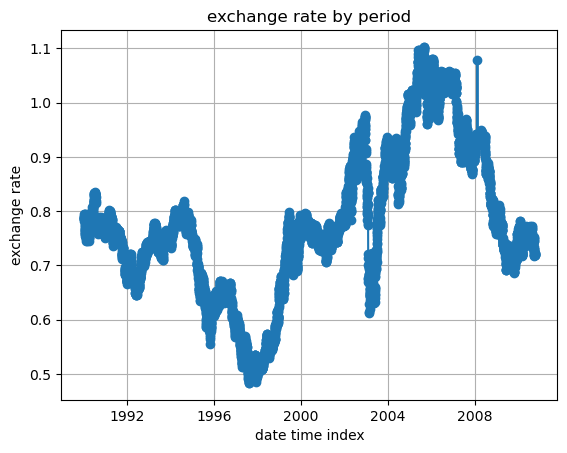

In [41]:
# 2.Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
import matplotlib.pyplot as plt
plt.plot(df.index,df['Ex_rate'],marker='o')
plt.xlabel('date time index')
plt.ylabel('exchange rate')
plt.title('exchange rate by period')
plt.grid(True)
plt.show()

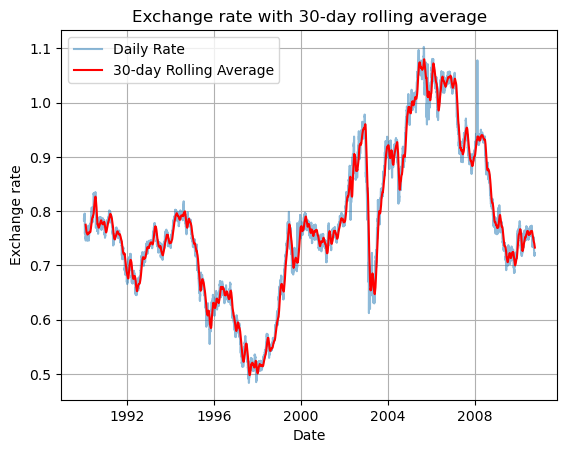

In [42]:
plt.plot(df['Ex_rate'],label= 'Daily Rate',alpha=0.5) #Rolling average to smooth short-term fluctuations
plt.plot(df['Ex_rate'].rolling(window=30).mean(),color='red',label='30-day Rolling Average')
plt.title('Exchange rate with 30-day rolling average')
plt.xlabel('Date')
plt.ylabel('Exchange rate')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\andeb\AppData\Local\Temp\ipykernel_10376\1963586888.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly= df['Ex_rate'].resample('M').mean()


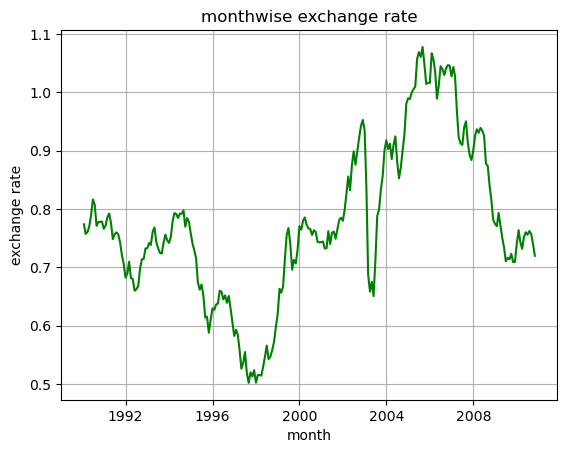

In [43]:
# Resample by month/year to see seasonality
# Monthly average:
df_monthly= df['Ex_rate'].resample('M').mean()
plt.plot(df_monthly,color='green')
plt.xlabel('month')
plt.ylabel('exchange rate')
plt.title('monthwise exchange rate')
plt.grid(True)
plt.show()

C:\Users\andeb\AppData\Local\Temp\ipykernel_10376\1491889633.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly=df['Ex_rate'].resample('Y').mean()


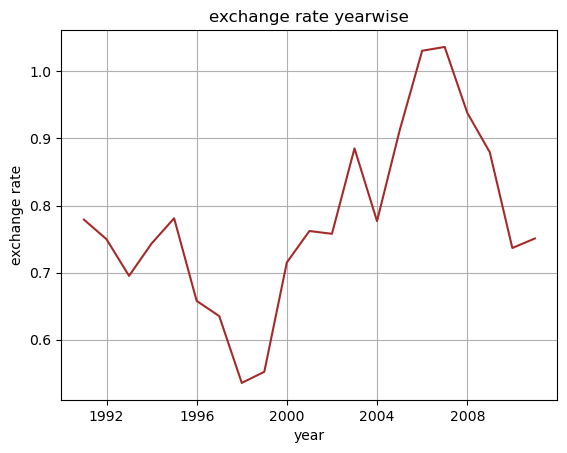

In [44]:
# yearly average
df_yearly=df['Ex_rate'].resample('Y').mean()
plt.plot(df_yearly,color='brown')
plt.xlabel('year')
plt.ylabel('exchange rate')
plt.title('exchange rate yearwise')
plt.grid(True)
plt.show()

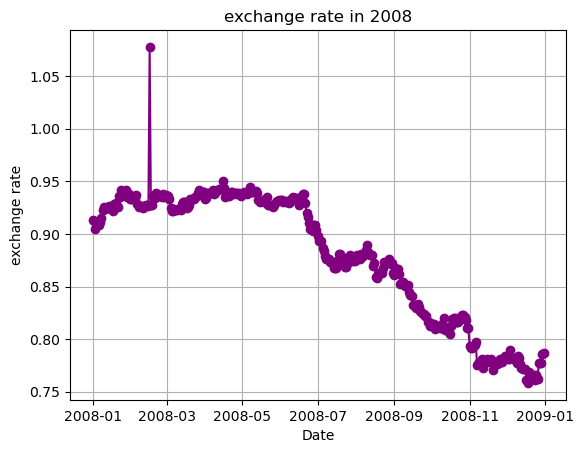

In [45]:
plt.plot(df['2008-01-01':'2008-12-31'],color='purple',marker='o')
plt.title('exchange rate in 2008')
plt.xlabel('Date')
plt.ylabel('exchange rate')
plt.grid(True)
plt.show()

In [46]:
# 3.Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.
df.isnull().sum() # There are no null values in the given data set.

Ex_rate    0
dtype: int64

In [47]:
#anomalies identified during the exploration phase.
rolling_mean=df['Ex_rate'].rolling(window=30).mean()
rolling_std = df['Ex_rate'].rolling(window=30).std()

In [48]:
import numpy as np # Anomalies: points more than 3 std away from rolling mean
anomalies=np.abs(df['Ex_rate'] - rolling_mean)>3 *rolling_std

In [49]:
df['Ex_rate'][anomalies]= rolling_mean[anomalies] # repalcing the anomalies with the rolling mean

C:\Users\andeb\AppData\Local\Temp\ipykernel_10376\3127718493.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Ex_rate'][anomalies]= rolling_mean[anomalies] # repalcing the anomalies with the rolling mean


<Axes: title={'center': 'Cleaned Exchange Rate'}, xlabel='date'>

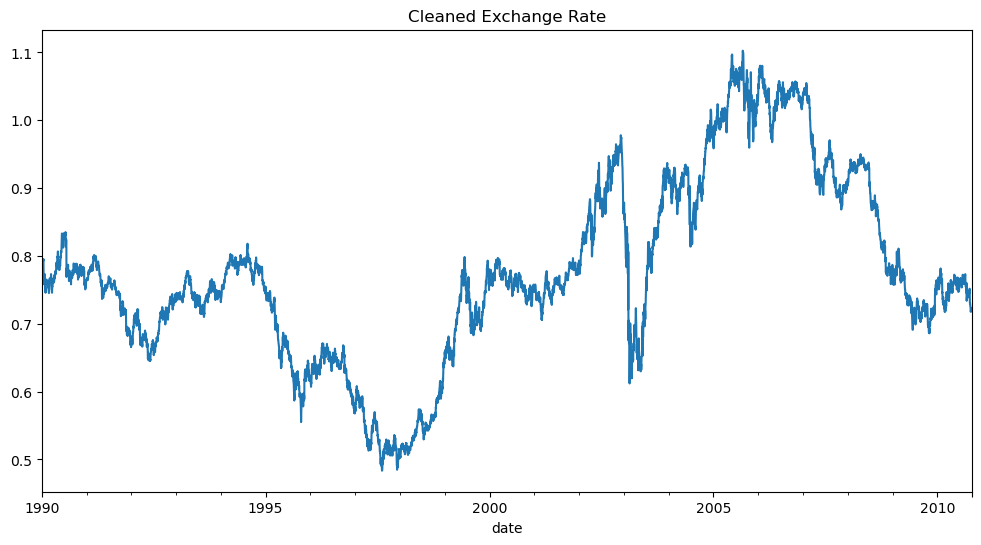

In [50]:
df['Ex_rate'].plot(figsize=(12,6), title='Cleaned Exchange Rate') # the anomalies are replaced with the rolling mean

In [51]:
# Part 2: Model Building - ARIMA
# 1.Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
# 2.Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
# 3.Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
# 4.Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [52]:
# Part 2: Model Building - ARIMA
# 1.Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model
# for one or more currency time series.
# First we have to find our data is stationary or not using agumented dickey fuller test
from statsmodels.tsa.stattools import adfuller
results =adfuller(df['Ex_rate'])
print('ADF Statistics:',np.round(results[0],2))
print('p_value:',np.round(results[1],2))

ADF Statistics: -1.75
p_value: 0.41


In [53]:
# p_value is 0.41, which is greater than 0.05 which means our time series data is not stationary.
# Now we have to apply differencing
df_diff= df['Ex_rate'].diff().dropna()

In [54]:
results =adfuller(df_diff)
print('ADF Statistics:',np.round(results[0],2))
print('p_value:',np.round(results[1],2))

ADF Statistics: -14.75
p_value: 0.0


In [55]:
# p_value is 0.0 which is less than 0.05 ,so our time series data is now stationary. So our d=1.

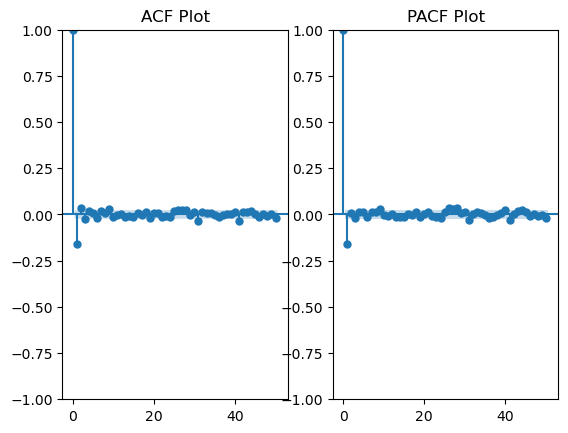

In [56]:
# Now finding p and q values using the plot of ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.subplot(121)
plot_acf(df_diff,lags=50,ax=plt.gca()) # gives q value
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(df_diff,lags=50,ax=plt.gca()) # gives p value
plt.title('PACF Plot')
plt.show()

In [57]:
# from the above plot p=1 ,q=1 and d=1

In [58]:
# 2.Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
from statsmodels.tsa.arima.model import ARIMA
model= ARIMA(df['Ex_rate'],order=(1,1,1))
model_fit = model.fit()

C:\Users\andeb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andeb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andeb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [59]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28144.702
Date:                Tue, 23 Dec 2025   AIC                         -56283.404
Time:                        11:16:21   BIC                         -56262.602
Sample:                    01-01-1990   HQIC                        -56276.265
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2321      0.028     -8.243      0.000      -0.287      -0.177
ma.L1          0.0726      0.031      2.305      0.021       0.011       0.134
sigma2      3.511e-05   1.89e-07    185.721      0.0

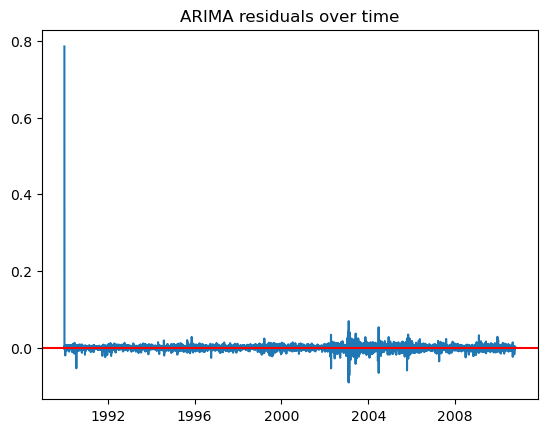

In [60]:
# 3.Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
residuals = model_fit.resid
# plotting residuals over time
plt.plot(residuals)
plt.title('ARIMA residuals over time')
plt.axhline(0,color='red')
plt.show()

In [61]:
# Most residuals fluctuate closely around the red zero line.
#This indicates the model’s mean structure is well captured.

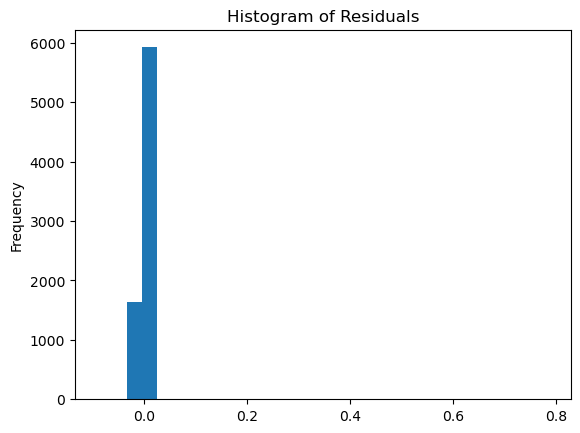

In [62]:
residuals.plot(kind='hist',bins=30,title='Histogram of Residuals')
plt.show()

In [63]:
# The histogram of residuals shows an approximately normal distribution centered around zero, indicating that the residuals behave like white noise. 
# Therefore, there is no evidence of model inadequacy, and the ARIMA model is adequate.

In [68]:
# 4.Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.
# spliting the data first
train_size= int(len(df['Ex_rate'])*0.8)
train,test= df['Ex_rate'][:train_size],df['Ex_rate'][train_size:]
# Fit ARIMA model on train data
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train,order=(1,1,1))
model_fit= model.fit()
# Forecasting on the test period
n_forecast= len(test)
forecast= model_fit.forecast(steps= n_forecast)

C:\Users\andeb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andeb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andeb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


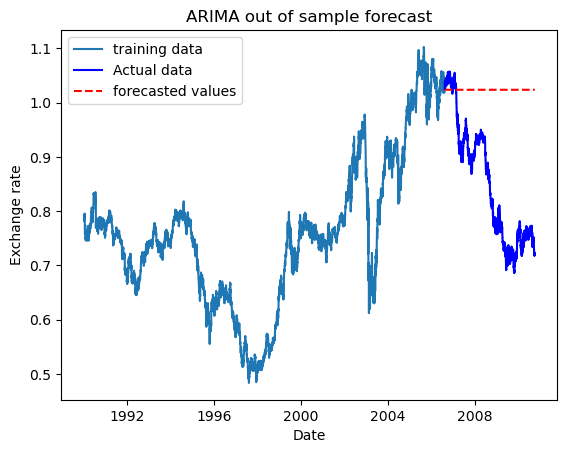

In [69]:
# visualize the forecast vs actual
import matplotlib.pyplot as plt
plt.plot(train.index,train,label='training data')
plt.plot(test.index,test,label='Actual data',color='blue')
plt.plot(test.index,forecast,label='forecasted values',color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Exchange rate')
plt.title('ARIMA out of sample forecast')
plt.legend()
plt.show()

In [70]:
# Part 3: Evaluation and Comparison
# 1.Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
# 2.Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
# 3.Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this 
# dataset.

In [80]:
# Part 3: Evaluation and Comparison
# 1.Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
mae = mean_absolute_error(test,forecast)
mse = mean_squared_error(test,forecast)
print(f"mean absolute error for ARIMA model is {np.round(mae,2)}")
print(f"mean squared error ARIMA model is {np.round(mse,2)}")

mean absolute error for ARIMA model is 0.18
mean squared error ARIMA model is 0.04


In [81]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    nonzero = y_true !=0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) *100
mape= mean_absolute_percentage_error(test,forecast)
print(f"mean absolute percentage error for ARIMA model is {np.round(mape,2)}")

mean absolute percentage error for ARIMA model is 22.78


In [79]:
# Another model(navie forecast)
naive_forecast = test.shift(1).dropna()
actual = test.loc[naive_forecast.index]
# metrics for this model
mae_naive = mean_absolute_error(actual,naive_forecast)
mse_naive = mean_squared_error(actual,naive_forecast)
print(f"mean absolute error for naive model is {np.round(mae_naive,2)}")
print(f"mean squared error for naive model is {np.round(mse_naive,2)}")
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_naive= mape(actual,naive_forecast)
print(f"mean absolute percentage error for naive model is {np.round(mape_naive,2)}")

mean absolute error for naive model is 0.0
mean squared error for naive model is 0.0
mean absolute percentage error for naive model is 0.39


In [82]:
# 2.Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
# Metrics for ARIMA model: 
# mean absolute error for ARIMA model is 0.18
# mean squared error ARIMA model is 0.04
# mean absolute percentage error for ARIMA model is 22.78

# Metrics for naive model:
# mean absolute error for naive model is 0.0
# mean squared error for naive model is 0.0
# mean absolute percentage error for naive model is 0.39

# Performance Discussion:
# Although the naive model shows lower error metrics, this performance is largely due to the high persistence in the exchange rate series.
# The naive model benefits from using the last observed value, which closely matches the next observation in a stable period.
# The ARIMA model shows higher errors in this short out-of-sample window, possibly due to model estimation uncertainty.

# Advantages:
# For ARIMA model:
# Captures underlying autocorrelation and trend structure
# More robust for longer-term forecasting
# Statistically interpretable
# For Navie model:
# Extremely simple and computationally efficient
# Performs well when the series exhibits strong persistence

# Limitations:
# For ARIMA model:
# Sensitive to parameter selection
# May underperform naïve models over short, stable periods
# Assumes linear dynamics
# For Navie model:
# Lacks theoretical structure
# Cannot capture trend changes or turning points
# Not reliable for longer-term forecasting

In [ ]:
#3.Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.
# Residual diagnostics showed that the ARIMA model was adequate.
# Based on the observed error metrics, the naive model achieved lower forecast errors during the test period due to the strong persistence 
# and stability of the exchange rate series. 
# However, the ARIMA model provides a more robust and theoretically sound framework by modeling trend and autocorrelation.
# Overall, the naïve model yielded the best short-term forecasting performance for this dataset, 
# while the ARIMA model remains more suitable for longer-term forecasting and more dynamic exchange rate behavior.